t-cells in my simulation have a radius of 7 voxels, which is a diameter of 14 voxels
14 voxels in diameter should be µm 14 if 1 voxel = 1 µm
based on this, sinusoids should be 7-21 voxels in diameter, thus 7-21 µm - from literature (7-15um)

In [ ]:
#dilate voxels below 7 and erode above 21
import numpy as np
from skimage.morphology import skeletonize_3d, ball, binary_dilation
from scipy.ndimage import distance_transform_edt
import os

dimension = 768
# File info with input and output paths for the two datasets
file_info = [
    {
        "name": "AK_FV",
        "input": f"/home/arawa/Shabaz_simulation/segmentedSinusoids_npz/segmentedSinusoids_AK_FV_cropped{dimension}_new.npz",
        "output": f"/home/arawa/Shabaz_simulation/segmentedSinusoids_npz/segmentedSinusoids_AK_FV_cropped{dimension}_new_adjusted.npz"
    # },
    # {
    #     "name": "Levy_walks",
    #     "input": f"/home/arawa/Shabaz_simulation/figure_7_ak/segmentedSinusoids_Levy_walks_liver/flipped_IMG_3D_cropped{dimension}_new.npz",
    #     "output": f"/home/arawa/Shabaz_simulation/figure_7_ak/segmentedSinusoids_Levy_walks_liver/flipped_IMG_3D_cropped{dimension}_new_adjusted.npz"
    }
]

# Loop through each file info entry
for file in file_info:
    # Load segmented sinusoid structure
    input_file_path = file["input"]
    output_file_path = file["output"]
    
    liver = np.load(input_file_path)["image"]

    # Ensure binary segmentation
    threshold = 0.5  
    binary_liver = liver > threshold

    # Compute the 3D skeleton
    skeleton = skeletonize_3d(binary_liver)
    skeleton = skeleton.astype(bool)

    # Compute the Euclidean distance transform
    dist_transform = distance_transform_edt(binary_liver)

    # Extract skeleton coordinates
    skel_coords = np.column_stack(np.where(skeleton))

    # Create a new expanded structure
    expanded_liver = binary_liver.copy()

    # Iterate through skeleton points
    for coord in skel_coords:
        z, y, x = coord
        r = dist_transform[z, y, x]  # Original radius
        d = 2 * r  # Original diameter

        # Adjust diameter if it's less than 7 voxels
        if d < 7:
            new_d = d + 5
        elif d > 21: 
            new_d = d - (d - 21)
        else:
            new_d = d

        new_r = int(np.ceil(new_d / 2))

        # Create a spherical structuring element
        sphere = ball(new_r)

        # Define bounding box
        z_min, z_max = max(0, z - new_r), min(liver.shape[0], z + new_r + 1)
        y_min, y_max = max(0, y - new_r), min(liver.shape[1], y + new_r + 1)
        x_min, x_max = max(0, x - new_r), min(liver.shape[2], x + new_r + 1)

        # Get the region to apply dilation
        region = expanded_liver[z_min:z_max, y_min:y_max, x_min:x_max]

        # Dilate the region using the sphere
        dilated_region = binary_dilation(region, footprint=sphere)

        # Update the expanded liver structure
        expanded_liver[z_min:z_max, y_min:y_max, x_min:x_max] = dilated_region

    # Save the modified structure
    np.savez_compressed(output_file_path, image=expanded_liver)
    print(f"Adjusted sinusoid structure for {file['name']} saved to {output_file_path}")


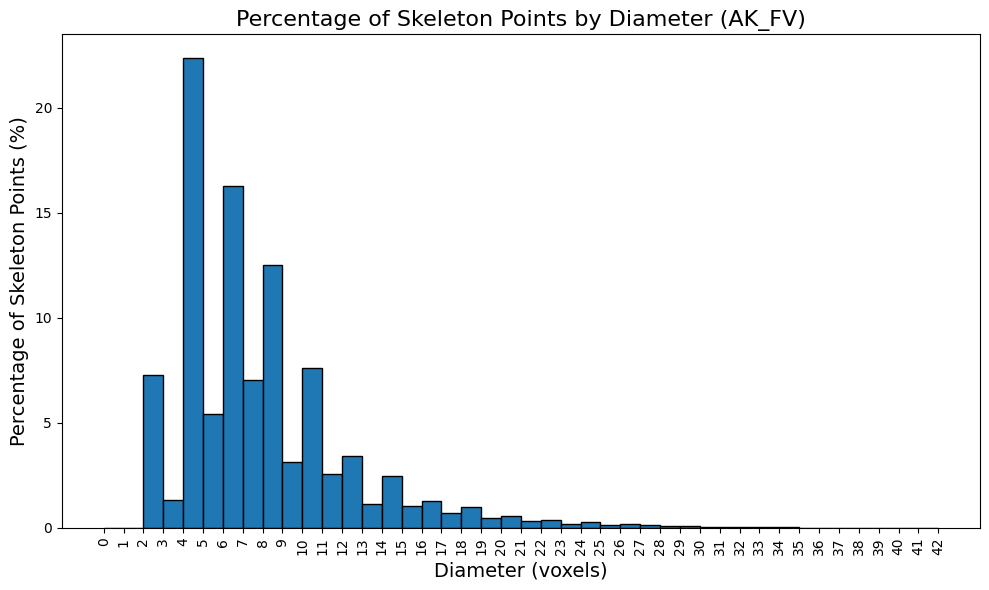

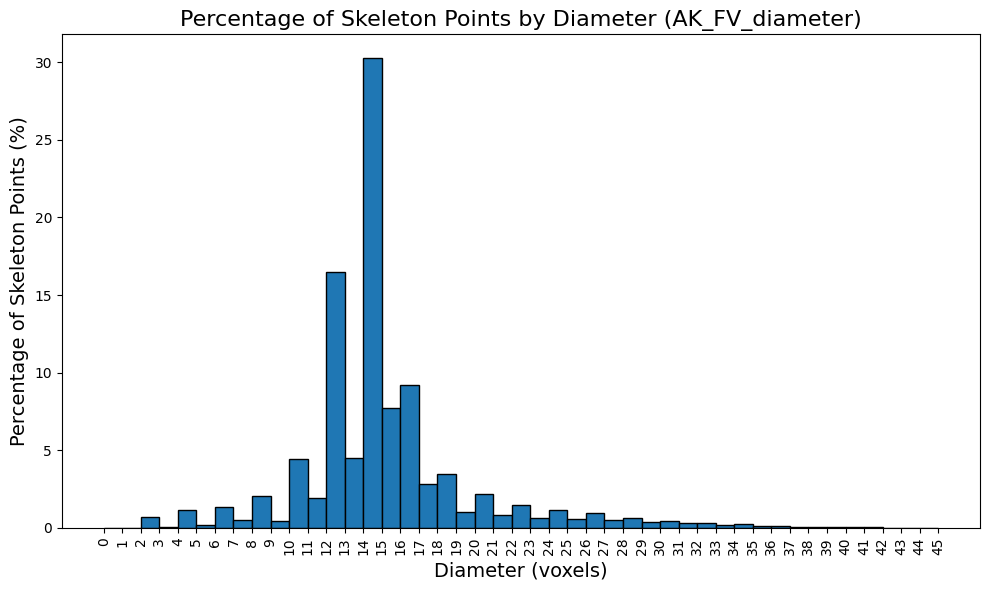

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from skimage.morphology import skeletonize_3d

dimension = 768
# File info with input paths for the adjusted structures
file_info = [
    {
        "name": "AK_FV",
        "input": f"/home/arawa/Shabaz_simulation/segmentedSinusoids_npz/segmentedSinusoids_AK_FV_cropped{dimension}_new.npz"
    },
    {
        "name": "AK_FV_diameter",
        "input": f"/home/arawa/Shabaz_simulation/segmentedSinusoids_npz/segmentedSinusoids_AK_FV_cropped{dimension}_new_adjusted.npz"
    # },    
    # {
    #     "name": "Levy walks",
    #     "input": f"/home/arawa/Shabaz_simulation/figure_7_ak/segmentedSinusoids_Levy_walks_liver/flipped_IMG_3D_cropped128_new.npz"
    # },
    #     {
    #     "name": "Levy_walks_diameter",
    #     "input": f"/home/arawa/Shabaz_simulation/figure_7_ak/segmentedSinusoids_Levy_walks_liver/flipped_IMG_3D_cropped128_new_adjusted.npz"
    }
]

# Loop through each file info entry
for file in file_info:
    # Load the adjusted structure
    adjusted_data = np.load(file["input"])["image"]

    # Ensure binary format
    binary_adjusted = adjusted_data > 0.5

    # Skeletonize the structure
    skeleton = skeletonize_3d(binary_adjusted)

    # Compute Euclidean Distance Transform (EDT)
    dist_transform = distance_transform_edt(binary_adjusted)

    # Extract skeleton coordinates
    skel_coords = np.column_stack(np.where(skeleton))

    # Compute diameters based on the maximum sphere that can fit through each skeleton point
    diameters = [2 * dist_transform[z, y, x] for z, y, x in skel_coords]

    # Define diameter bins (e.g., 0-1, 1-2, 2-3, etc.)
    max_diameter = np.max(diameters)
    bin_edges = np.arange(0, max_diameter + 1, 1)  # Create bins of size 1

    # Calculate histogram: count the number of skeleton points in each bin
    hist, bin_edges = np.histogram(diameters, bins=bin_edges)

    # Calculate percentage
    total_points = len(diameters)
    percentages = (hist / total_points) * 100

    # Plot the bar graph for diameter distribution
    plt.figure(figsize=(10, 6))
    plt.bar(bin_edges[:-1], percentages, width=1, edgecolor="black", align="edge")
    plt.xlabel("Diameter (voxels)", fontsize=16)
    plt.ylabel("Percentage of Skeleton Points (%)", fontsize=16)
    plt.title(f"Percentage of Skeleton Points by Diameter ({file['name']})", fontsize=20)
    plt.xticks(bin_edges, rotation=90)
    plt.tight_layout()
    #set dpi to 300 without saving
    plt.gcf().set_dpi(300)
    # Show the plot
    plt.show()


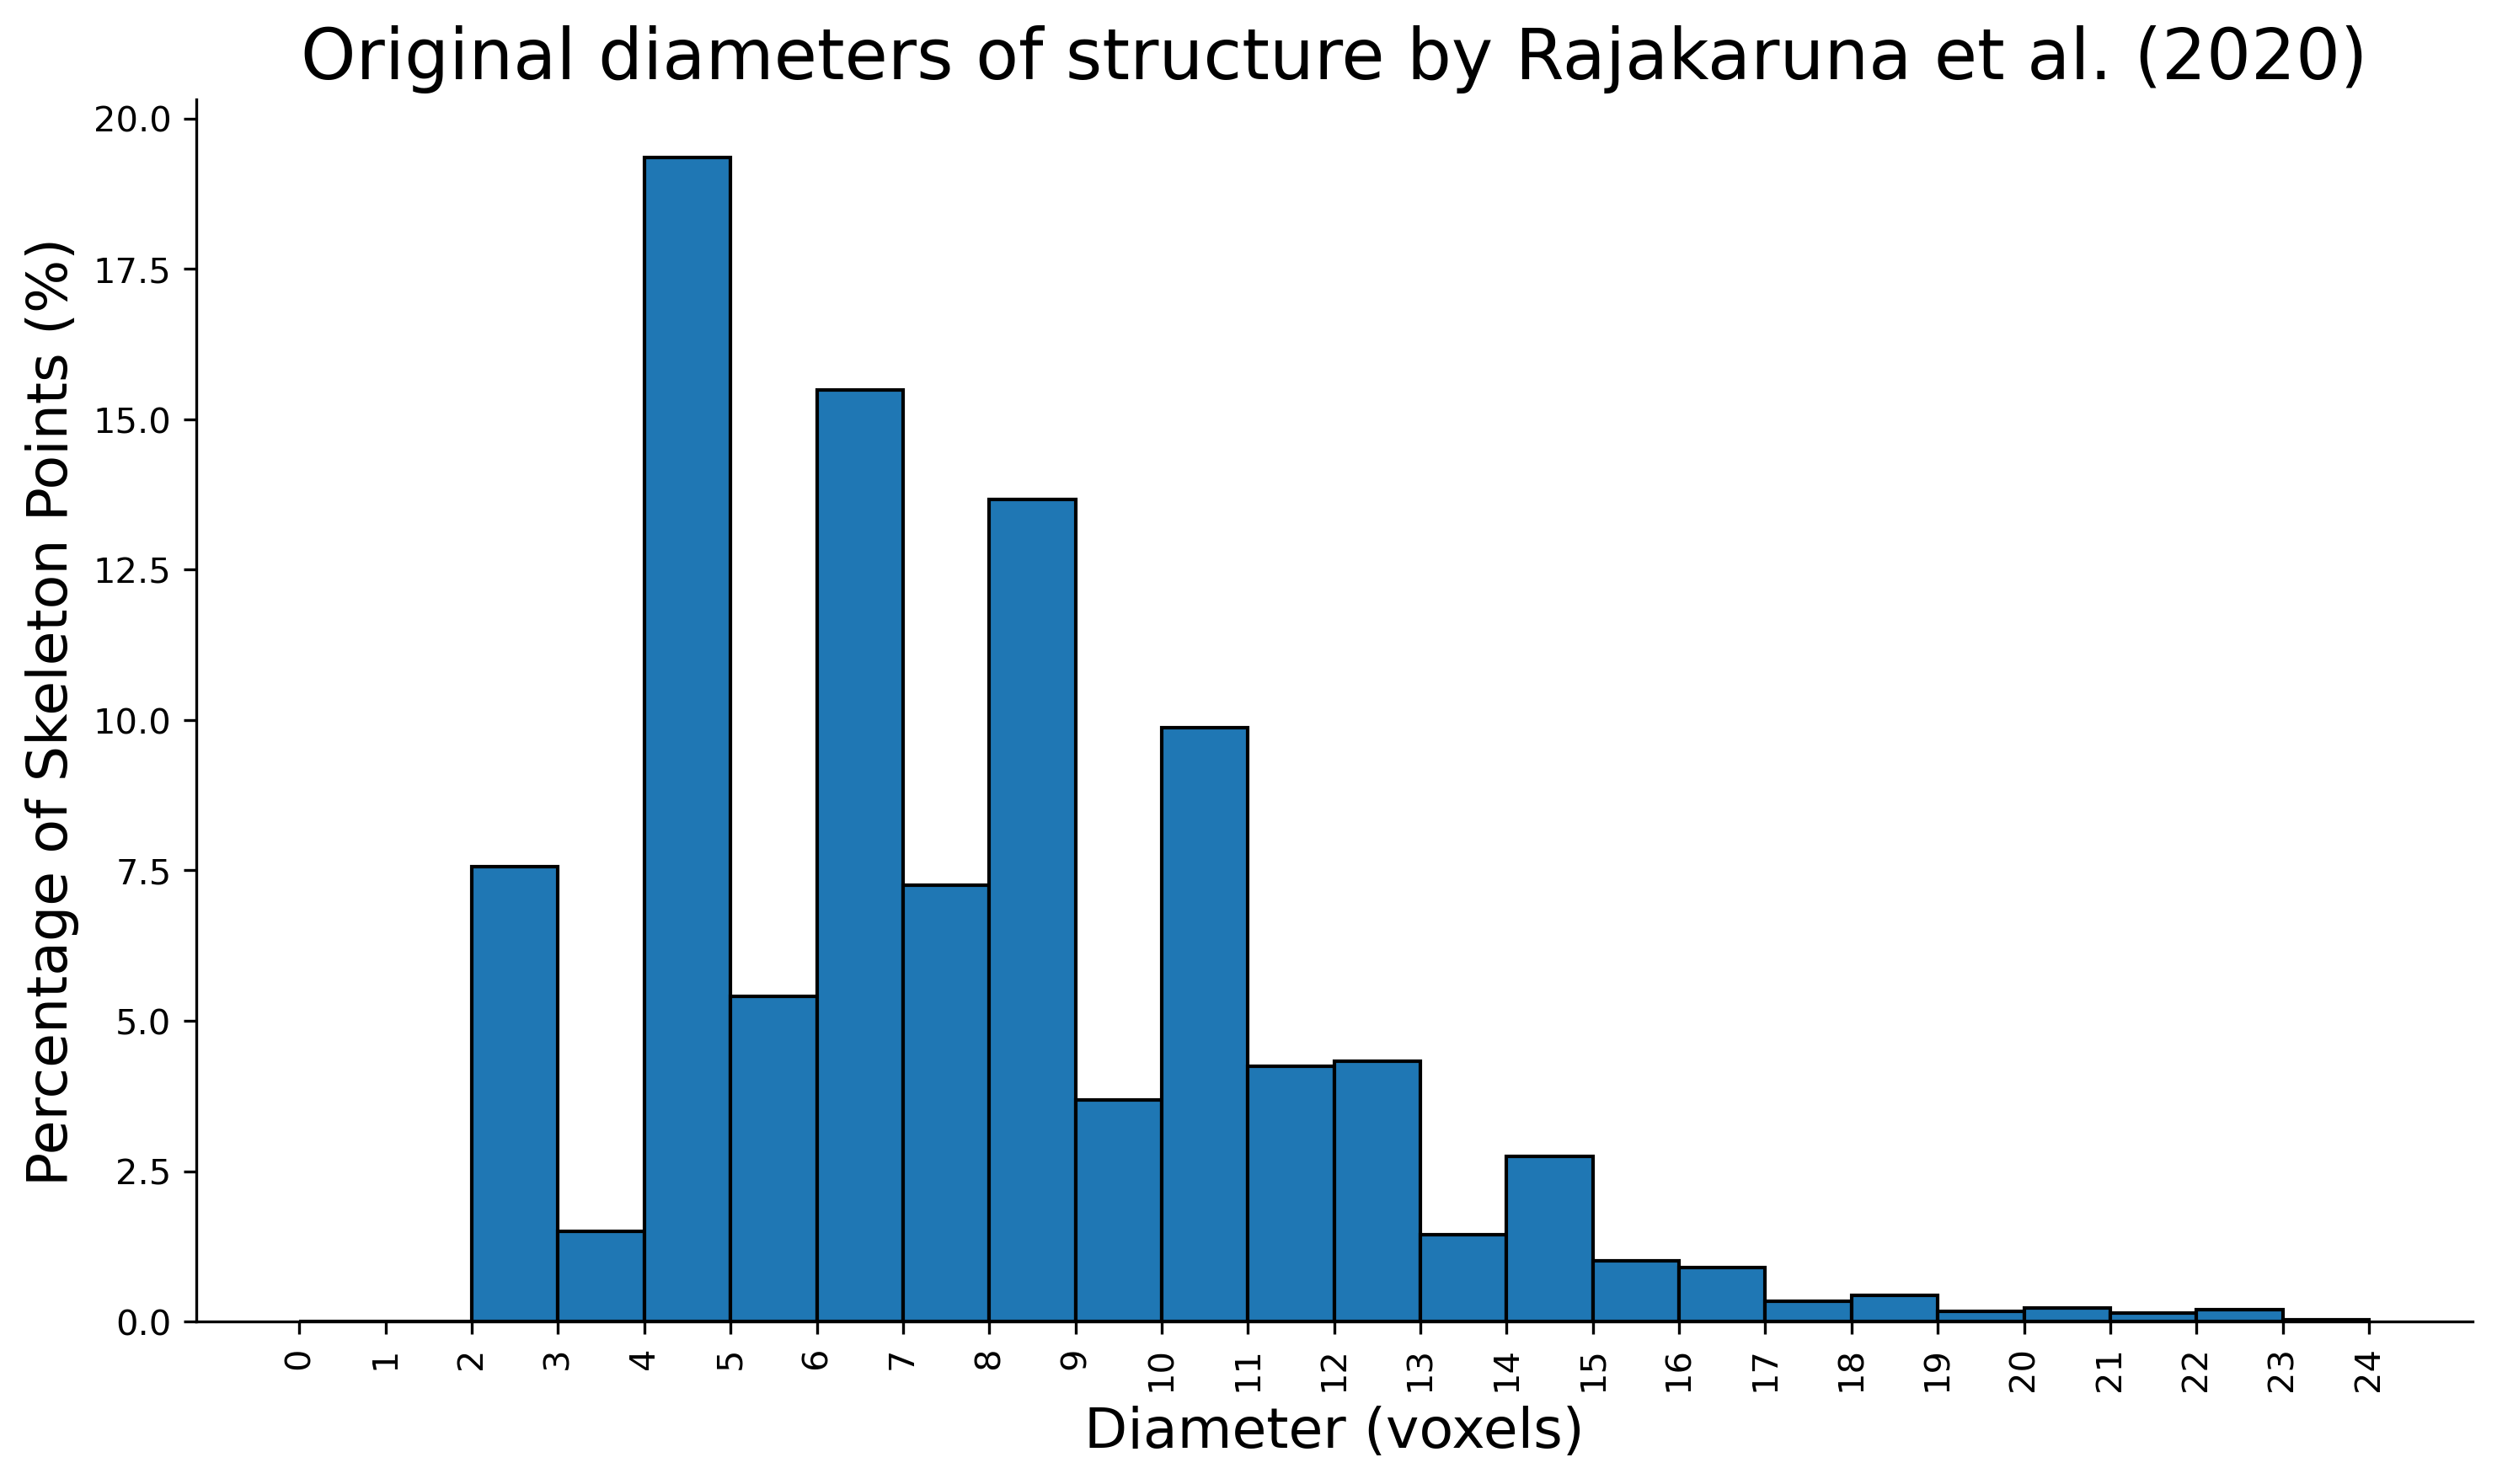

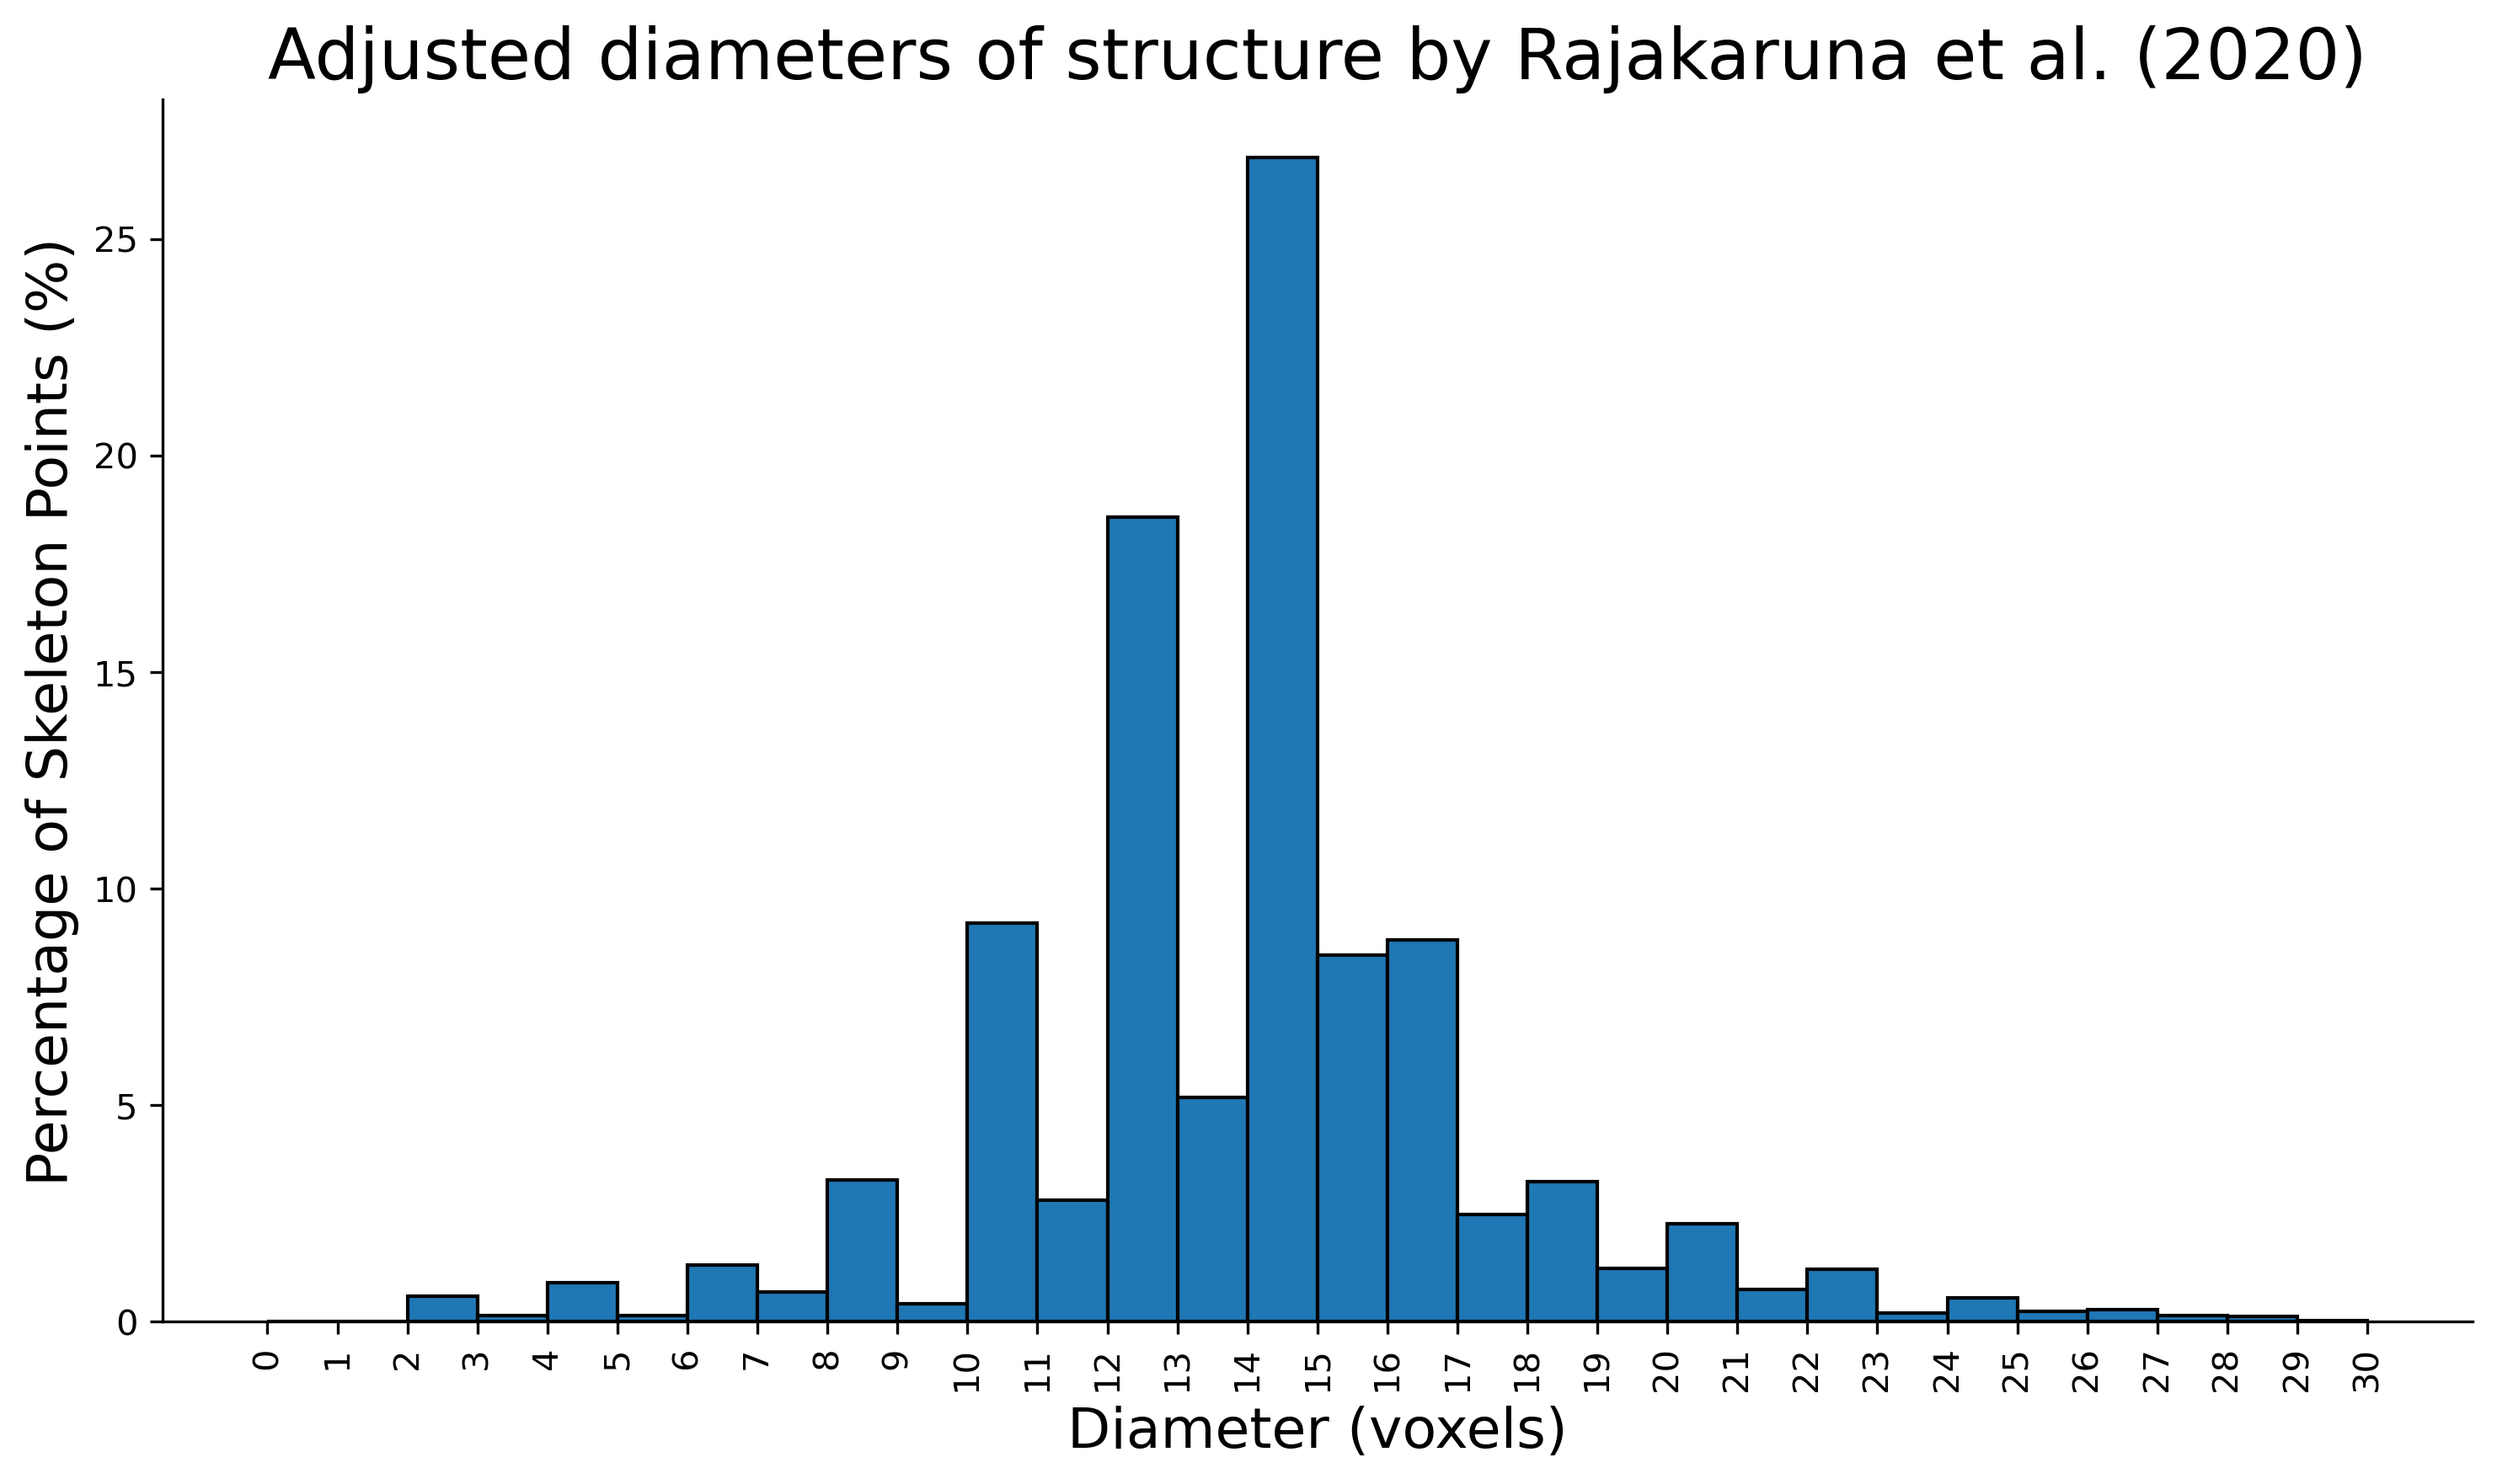

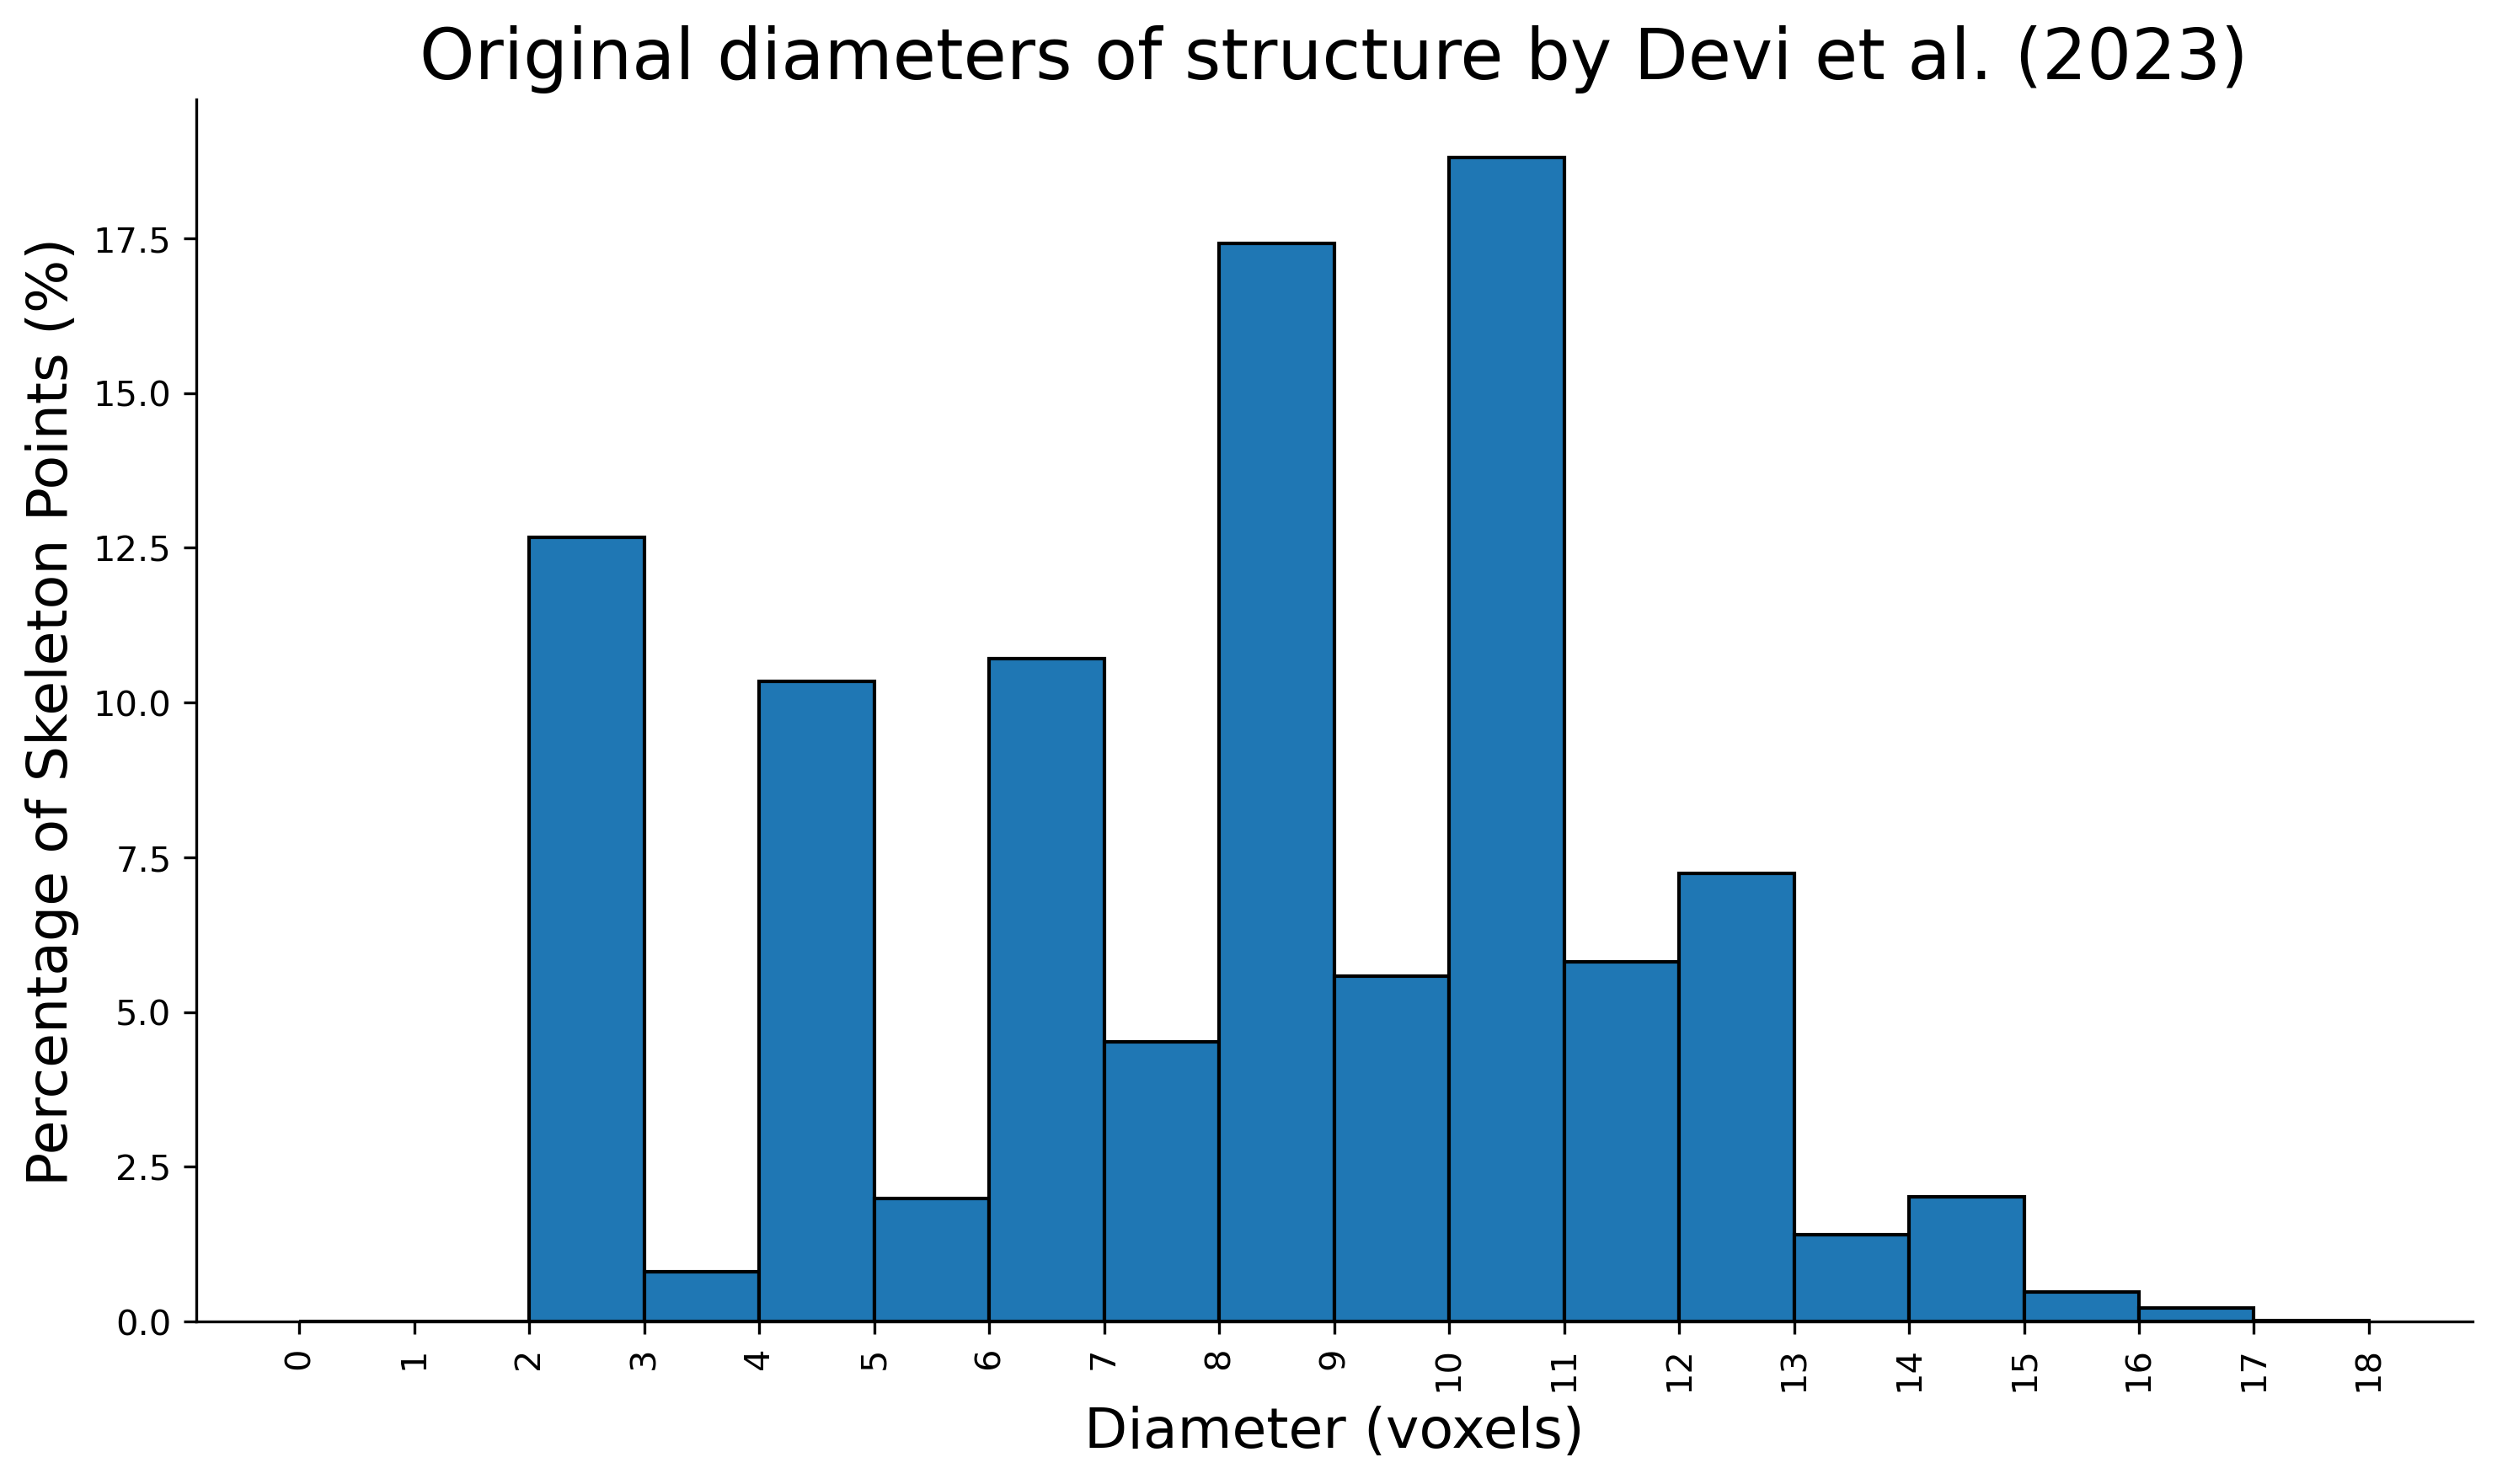

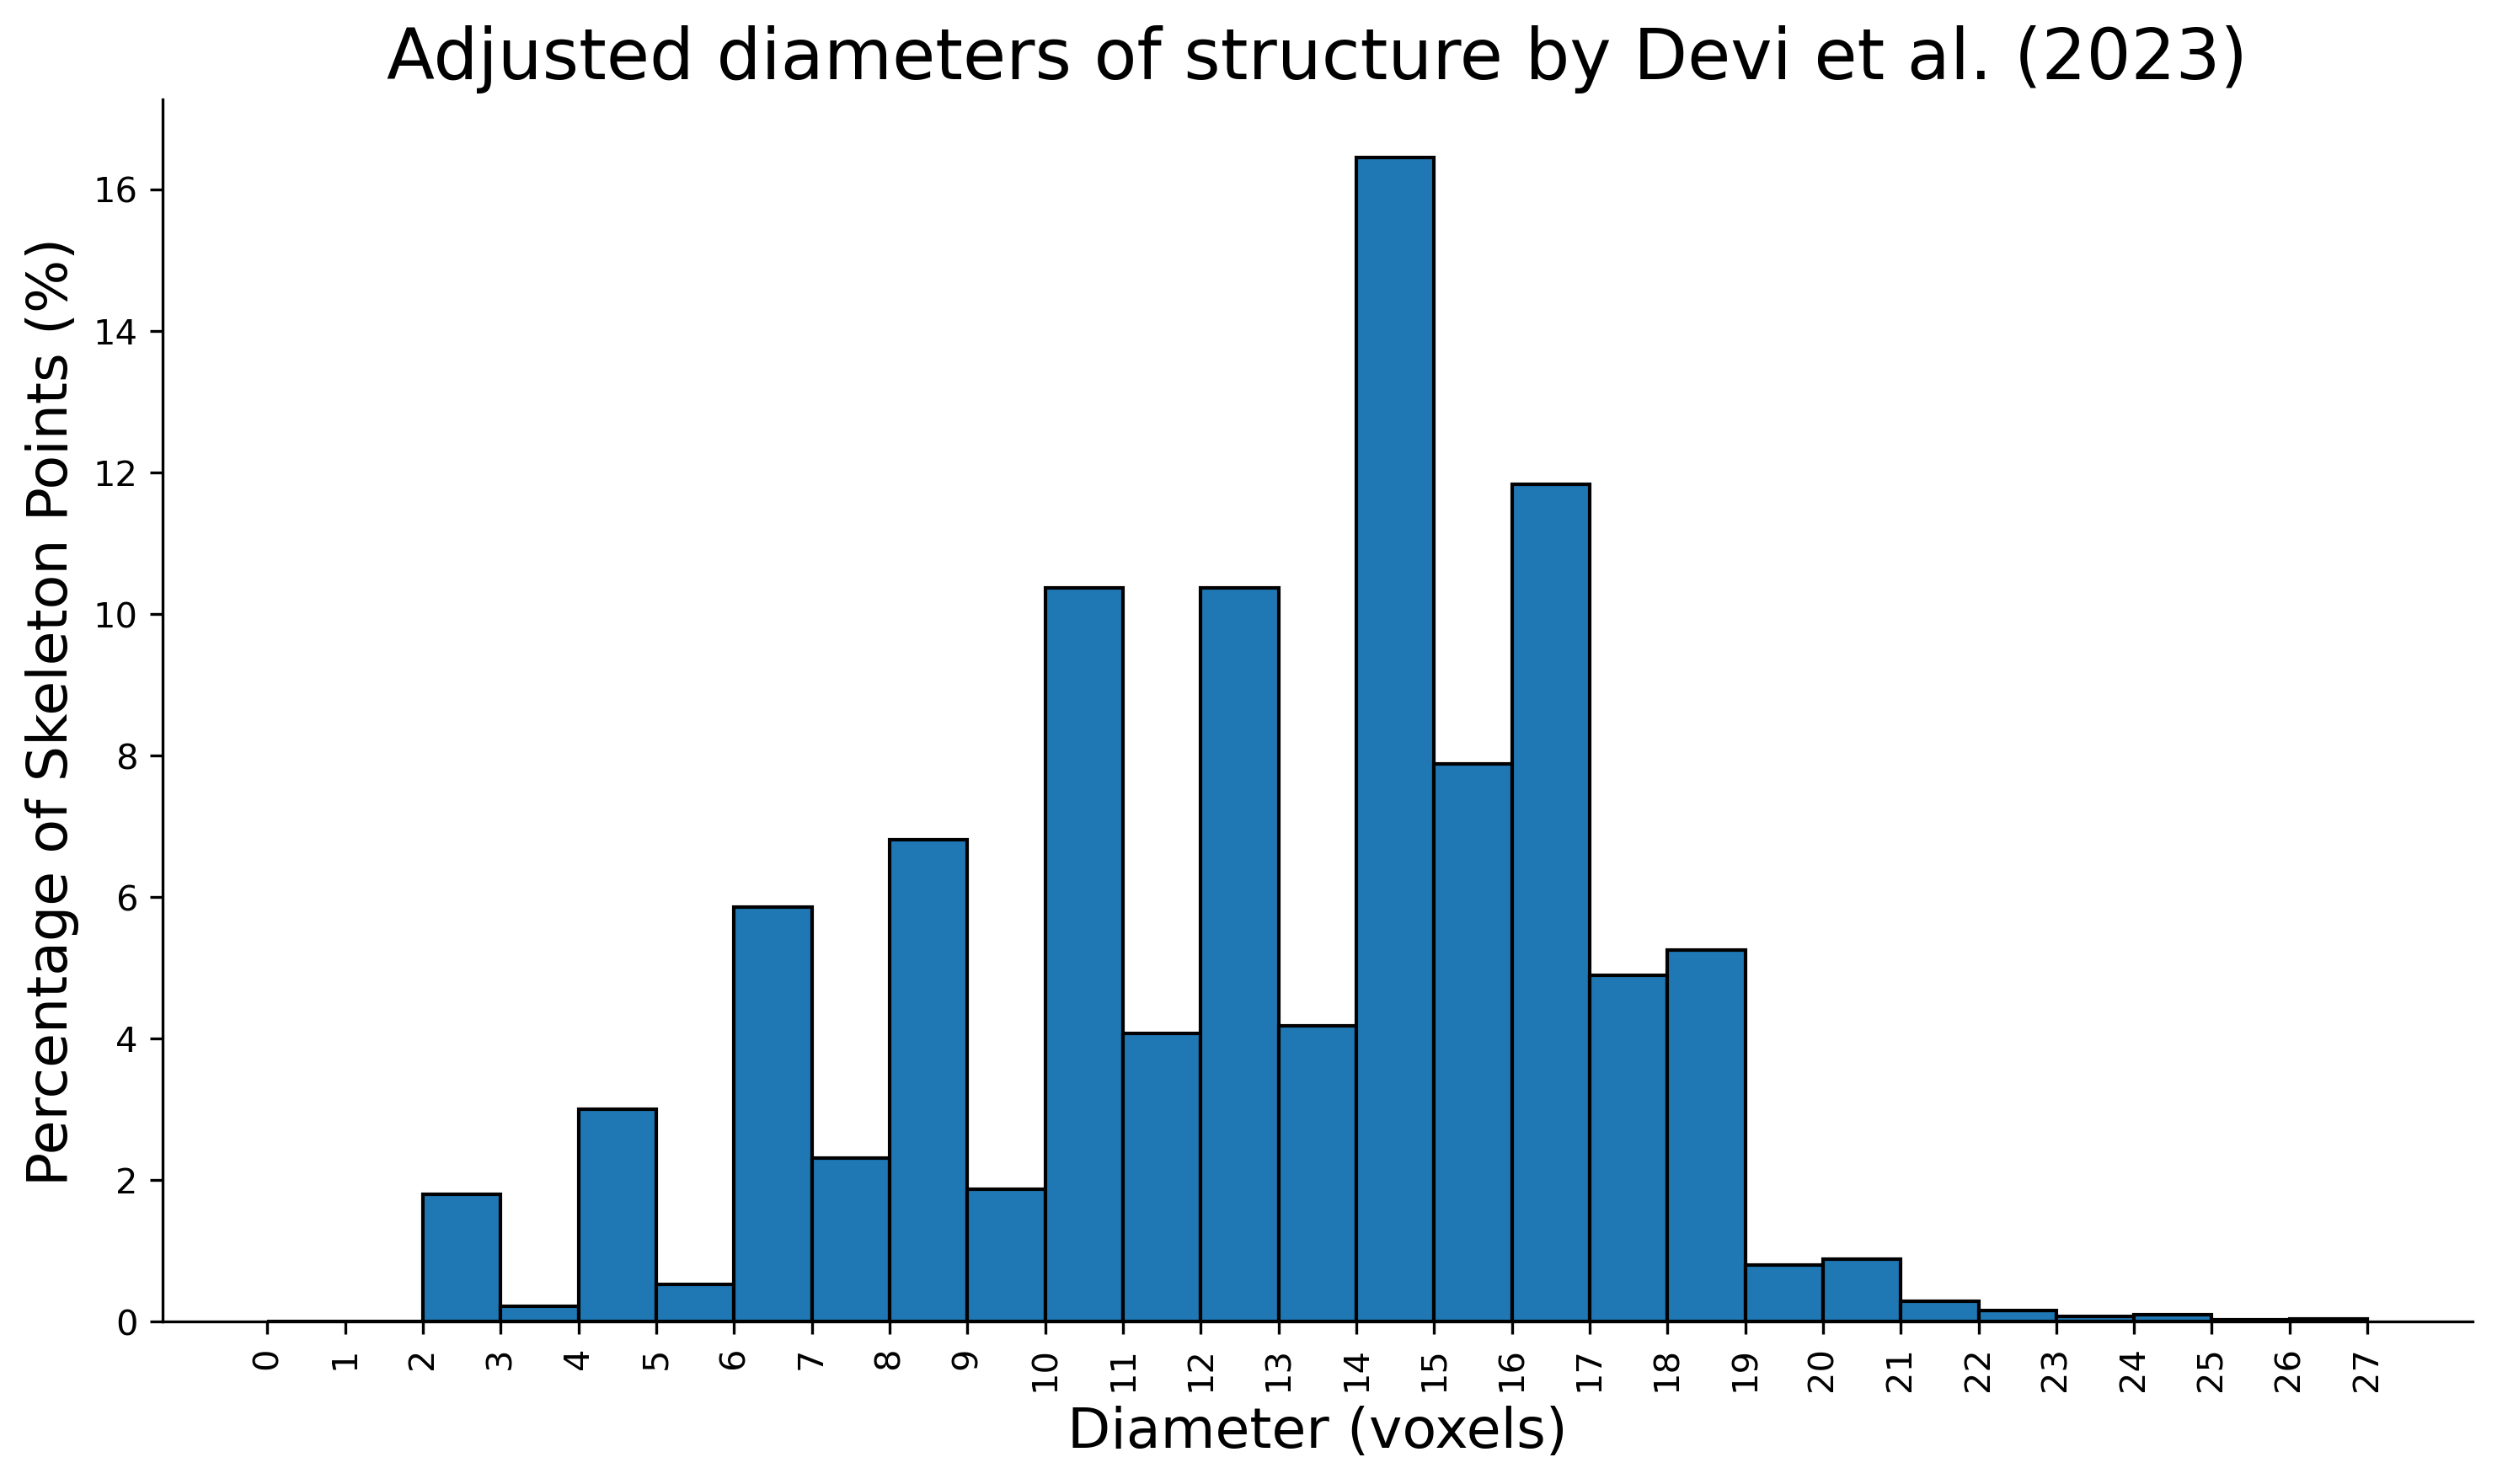

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from skimage.morphology import skeletonize

dimension = 128
# File info with input paths for the adjusted structures
file_info = [
    {
        "name": "Original diameters of structure by Rajakaruna et al. (2020",
        "input": f"/media/datadrive/arawa/3d_cpm_simulations/segmentedSinusoids_npz_old/segmentedSinusoids_AK_FV_cropped128_new.npz"
    },
    {
        "name": "Adjusted diameters of structure by Rajakaruna et al. (2020",
        "input": f"/media/datadrive/arawa/Shabaz_simulation_22_04_25/segmentedSinusoids_npz/segmentedSinusoids_AK_FV_cropped128_new_adjusted.npz"
     },    
     {
         "name": "Original diameters of structure by Devi et al. (2023",
         "input": f"/media/datadrive/arawa/Shabaz_simulation_22_04_25/figure_7_ak/segmentedSinusoids_Levy_walks_liver/flipped_IMG_3D_cropped128_new.npz"
     },
         {
         "name": "Adjusted diameters of structure by Devi et al. (2023",
         "input": f"/media/datadrive/arawa/Shabaz_simulation_22_04_25/figure_7_ak/segmentedSinusoids_Levy_walks_liver/flipped_IMG_3D_cropped128_new_adjusted.npz"
    }
]

# Loop through each file info entry
for file in file_info:
    # Load the adjusted structure
    adjusted_data = np.load(file["input"])["image"]

    # Ensure binary format
    binary_adjusted = adjusted_data > 0.5

    # Skeletonize the structure
    skeleton = skeletonize(binary_adjusted)

    # Compute Euclidean Distance Transform (EDT)
    dist_transform = distance_transform_edt(binary_adjusted)

    # Extract skeleton coordinates
    skel_coords = np.column_stack(np.where(skeleton))

    # Compute diameters based on the maximum sphere that can fit through each skeleton point
    diameters = [2 * dist_transform[z, y, x] for z, y, x in skel_coords]

    # Define diameter bins (e.g., 0-1, 1-2, 2-3, etc.)
    max_diameter = np.max(diameters)
    bin_edges = np.arange(0, max_diameter + 1, 1)  # Create bins of size 1

    # Calculate histogram: count the number of skeleton points in each bin
    hist, bin_edges = np.histogram(diameters, bins=bin_edges)

    # Calculate percentage
    total_points = len(diameters)
    percentages = (hist / total_points) * 100

    # Plot the bar graph for diameter distribution
    plt.figure(figsize=(10, 6))
    plt.bar(bin_edges[:-1], percentages, width=1, edgecolor="black", align="edge")
    plt.xlabel("Diameter (voxels)", fontsize=16)
    plt.ylabel("Percentage of Skeleton Points (%)", fontsize=16)
    plt.title(f"{file['name']})", fontsize=20)
    # remove top x axis and right y axis
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(bin_edges, rotation=90)
    plt.tight_layout()
    #set dpi to 300 without saving
    plt.gcf().set_dpi(300)
    # Show the plot
    plt.show()
